<a href="https://colab.research.google.com/github/AgniKoko/Fetal_ECG_Separation/blob/agni/Fetal_ECG_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Example



## Requirements

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wfdb
!pip install scikit-learn
!pip install matplotlib
!pip install pyedflib

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, spectrogram, stft, find_peaks
from scipy.fft import rfft, rfftfreq, irfft
from sklearn.decomposition import FastICA
import os
import zipfile
import pyedflib

In [ ]:
data_dir = '/content/drive/MyDrive/MAMAMONITOR/Fetal_ECG_Separation_GITNEW_r08'


print("Dataset extracted successfully.")

Dataset extracted successfully.


In [ ]:
# Define the path to the EDF file
rec = 'r08'
file_path = f'/content/drive/My Drive/MAMAMONITOR/ECG_Dataset/r08.edf'

# Open the EDF file so can start reading the data stored
f = pyedflib.EdfReader(file_path)

# Display the names of the channels
n_signals = f.signals_in_file  #Get the number of signal channels (e.g., 5 channels: 1 direct fetal, 4 abdominal)
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels) #print the names, 1 direct, 3 abdominal

# Read all channels and store them in a list
signals_list = [f.readSignal(i) for i in range(n_signals)]   #so signals_list[0] is Direct_1, signals_list[1] is Abdomen_1, and so on
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)  #1000 samples per second (1 kHz), which is very high-resolution ECG.

f._close()  # Close the file

# Load QRS annotations
qrs_annotations = wfdb.rdann(f"/content/drive/My Drive/MAMAMONITOR/ECG_Dataset/r08.edf", "qrs")

# Extract QRS peak sample indices
qrs_peaks = qrs_annotations.sample

print("QRS Peak Sample Indices:", qrs_peaks[:10])

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
QRS Peak Sample Indices: [ 206  652 1095 1538 1982 2428 2876 3332 3791 4265]


In [ ]:
rr_intervals = np.diff(qrs_peaks) #This takes your list of QRS peak positions (the heartbeats), and calculates the time between each beat in terms of sample count.
#np.diff subtracts each beat index from the next, so basically shows many samples passed between each heartbeat?
print("RR Intervals (samples):", rr_intervals[:10])

RR Intervals (samples): [446 443 443 444 446 448 456 459 474 476]


In [ ]:
#now  converting the RR intervals into something i can understand: time in seconds
rr_intervals_sec = rr_intervals / fs # dividing each RR interval (originally in samples) by the sampling frequency (fs = 1000), to convert it into seconds.
#If an RR interval was 800 samples: 800 / 1000 = 0.8 seconds between beats
print("RR Intervals (seconds):", rr_intervals_sec[:10])  #This just prints the first 10 beat-to-beat time gaps in seconds
min_rr = np.min(rr_intervals_sec)
print("Minimum RR Interval (seconds):", min_rr)   #This grabs the shortest RR interval in seconds from the entire list. Because it tells you the maximum heart rate. It’s useful for setting things like peak detection limits when analyzing fetal ECG. For example, a very fast heart rate = short RR

RR Intervals (seconds): [0.446 0.443 0.443 0.444 0.446 0.448 0.456 0.459 0.474 0.476]
Minimum RR Interval (seconds): 0.397


In [ ]:
instantaneous_hr_hz = 1 / rr_intervals_sec  #Heart rate (in Hz) is 1 divided by the time between beats, So if one beat took 0.8 seconds: That means the heart beats 1.25 times every second.
instantaneous_hr_bpm = instantaneous_hr_hz * 60  #converting from Hz to beats per minute (BPM), this is more ideal
print("Instantaneous Heart Rates (Hz):", instantaneous_hr_hz[:10])
print("Instantaneous Heart Rates (bpm):", instantaneous_hr_bpm[:10]) #Shows the first 10 HR values in BPM
print("Maximum Instantaneous HR(Hz):", np.max(instantaneous_hr_hz))
print("Maximum Instantaneous HR(BPM):", np.max(instantaneous_hr_bpm))



Instantaneous Heart Rates (Hz): [2.24215247 2.25733634 2.25733634 2.25225225 2.24215247 2.23214286
 2.19298246 2.17864924 2.10970464 2.10084034]
Instantaneous Heart Rates (bpm): [134.52914798 135.44018059 135.44018059 135.13513514 134.52914798
 133.92857143 131.57894737 130.71895425 126.58227848 126.05042017]
Maximum Instantaneous HR(Hz): 2.5188916876574305
Maximum Instantaneous HR(BPM): 151.13350125944584


## Testing

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
Shape of signals: (300000, 5)


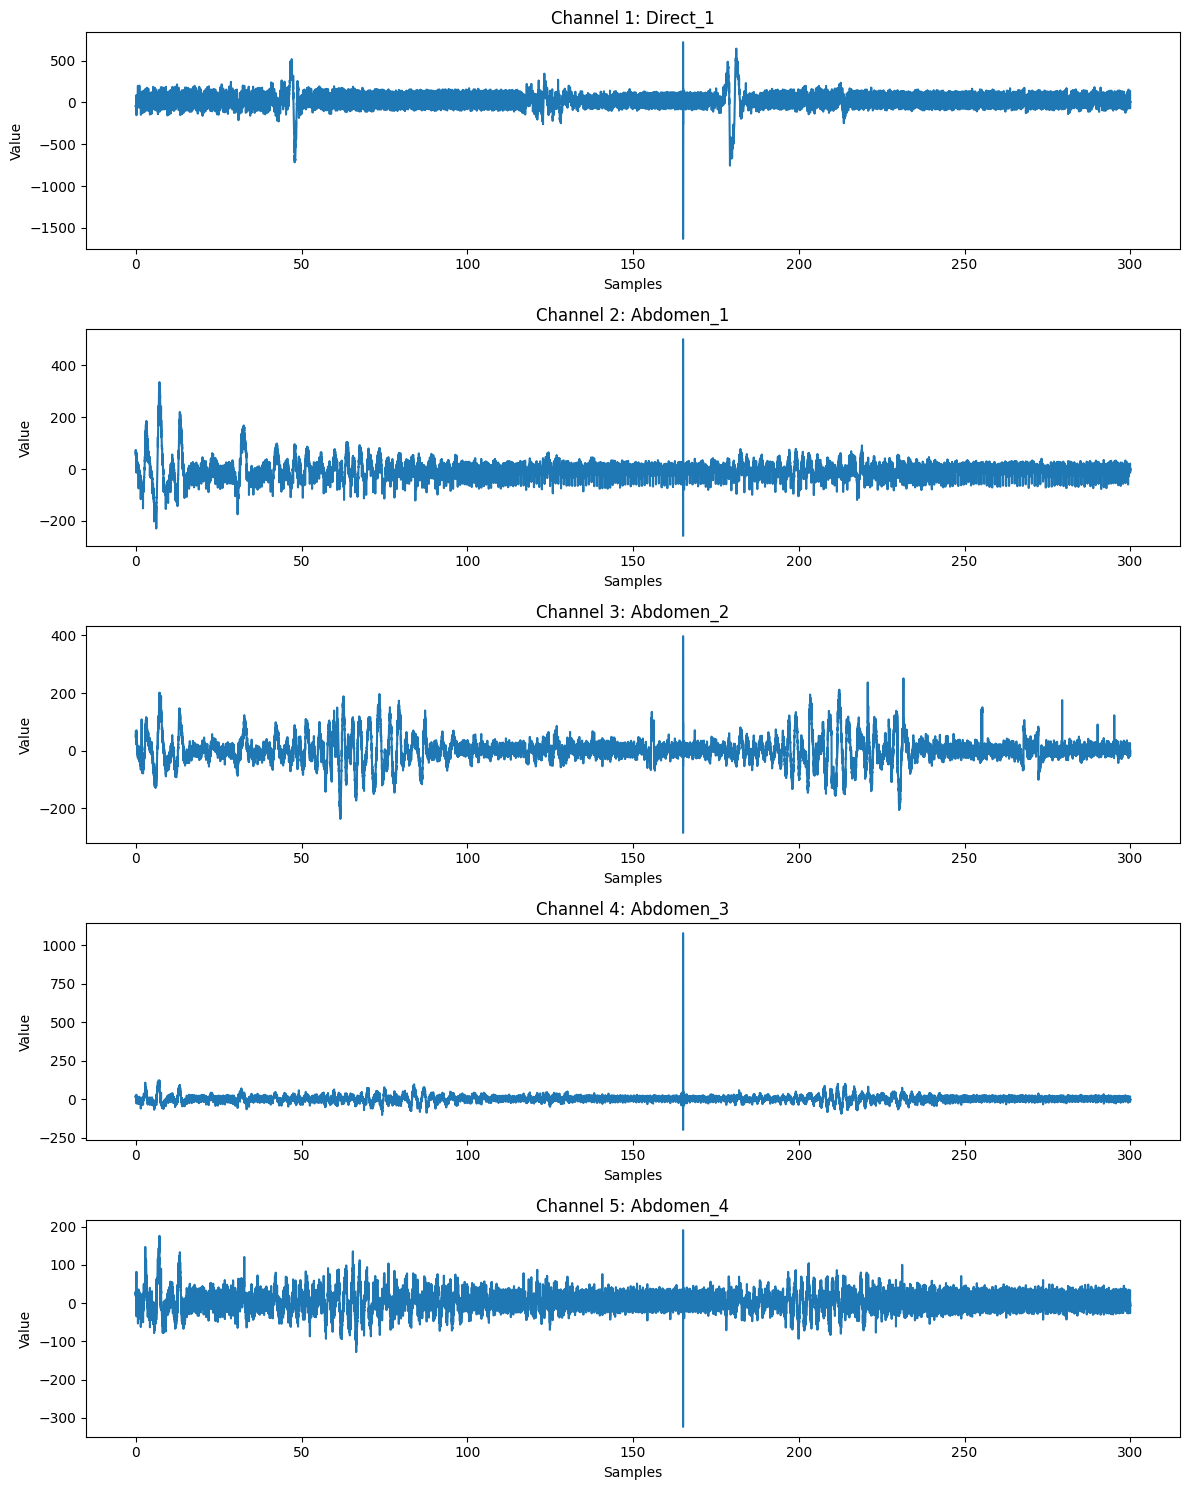

In [ ]:
# Set the path to the EDF file
file_path = f'/content/drive/My Drive/MAMAMONITOR/ECG_Dataset/r08.edf'

# Opening the EDF file
f = pyedflib.EdfReader(file_path)

# Displaying the names of the channels
n_signals = f.signals_in_file
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels)

#  Reading all channels and storing them in a lis
signals_list = [f.readSignal(i) for i in range(n_signals)]
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)

f._close()  # Closing the file

# Convert the list to a NumPy array and transpose to get shape (samples x channels)
signals = np.array(signals_list).T
print("Shape of signals:", signals.shape)

n_samples = signals.shape[0]
time = np.arange(n_samples) / fs
n_channels = signals.shape[1]

plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(time, signals[:, i])
    plt.title(f'Channel {i+1}: {signal_labels[i]}')
    plt.xlabel('Samples')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


Demixing Matrix W:
 [[ 0.01074712 -0.02520836  0.00739857  0.01027966]
 [ 0.0171451  -0.00443479 -0.02030841 -0.03308517]
 [-0.02761123  0.0005021  -0.00469414 -0.00483543]]
Demixing Matrix W shape:
 (3, 4)


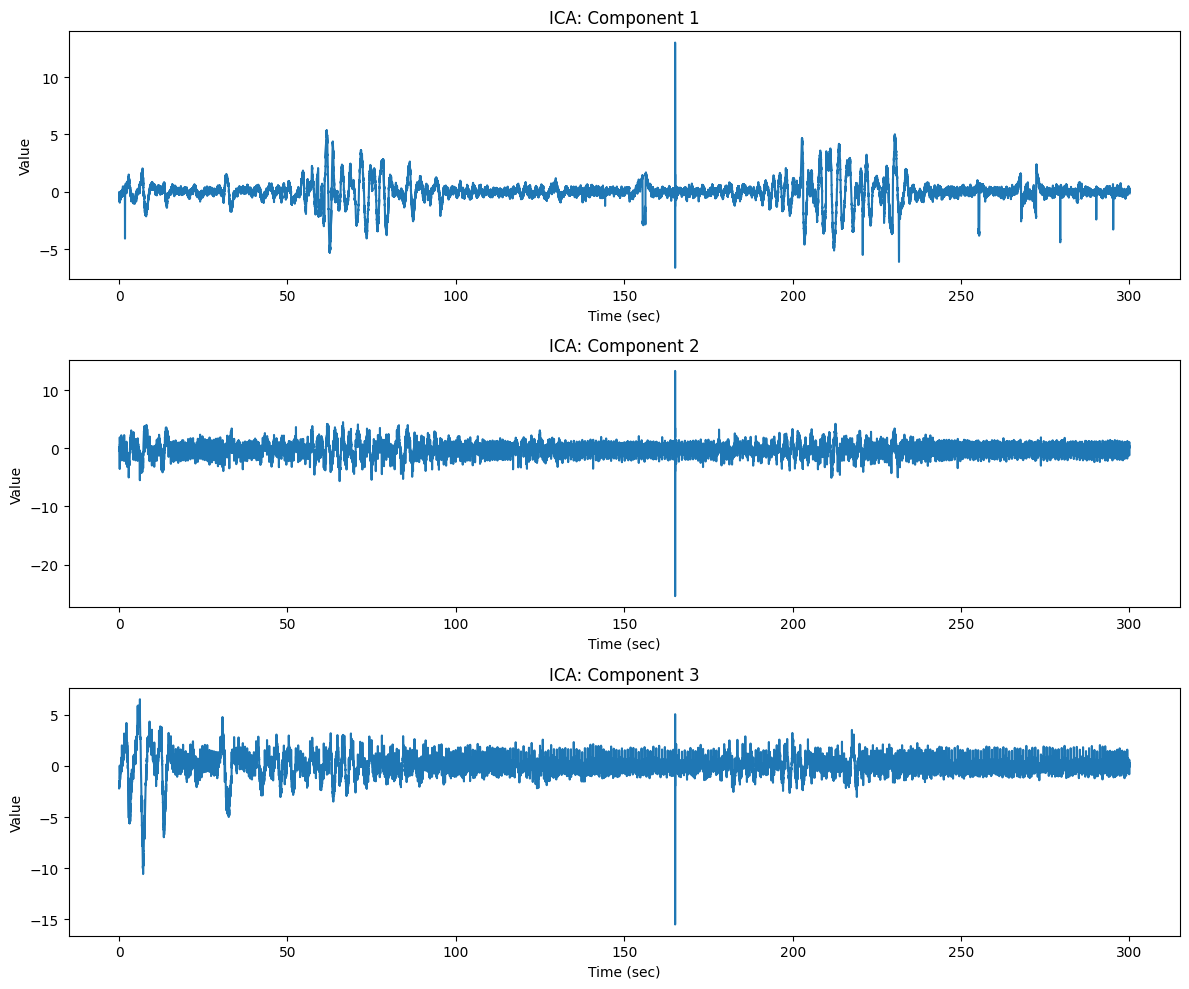

(300000, 5)
ica_components.shape: (300000, 3)


In [ ]:
#separate it into independent components
# Apply ICA with a number of components (e.g. 3) I want  to separate the signal into 3 different sources, in this case, maternal, fetal and possibly some noisy
n_components = 3

ica = FastICA(n_components, whiten="unit-variance")  #setting up the algorithm using FastICA
# ica_components = ica.fit_transform(signals)
S_ = ica.fit_transform(signals[:,1:])  #taking the signals from channels 1 to 4 which are the abdominal electrodes and feeding them into the ICA
W = ica.components_

ica_components = S_

print("Demixing Matrix W:\n", W)
print("Demixing Matrix W shape:\n", W.shape)

time = np.arange(ica_components.shape[0]) / fs

#plotting the separated signals
plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    plt.subplot(ica_components.shape[1], 1, i + 1)
    plt.plot(time, ica_components[:, i])
    plt.title(f'ICA: Component {i+1}')
    plt.xlabel('Time (sec)')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

print(signals.shape)
print("ica_components.shape:", ica_components.shape)

# FFT


<Figure size 1200x1000 with 0 Axes>

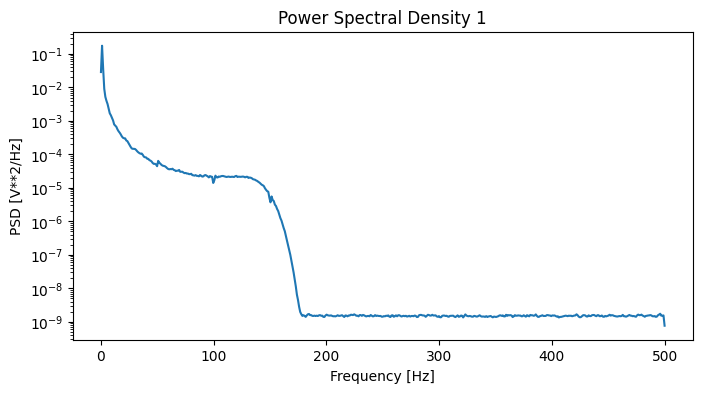

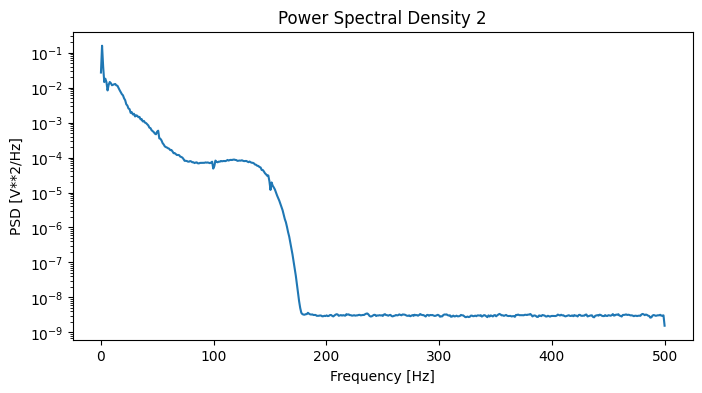

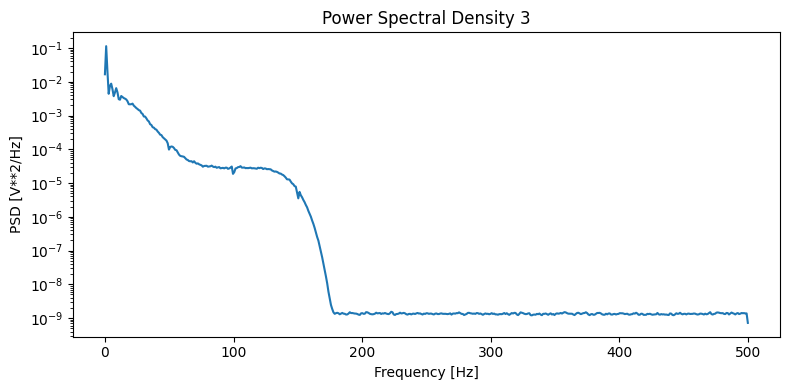

<Figure size 1200x1000 with 0 Axes>

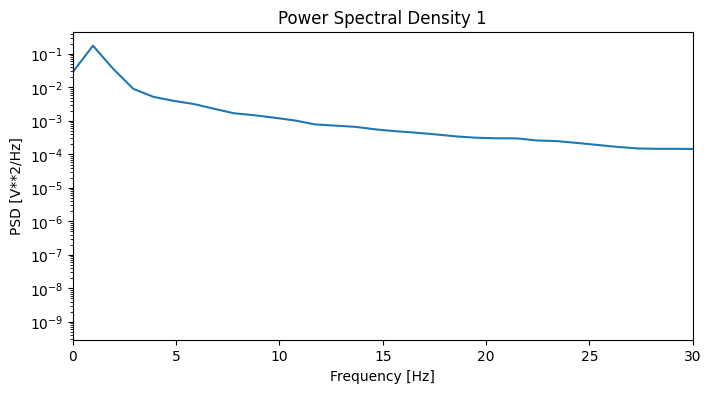

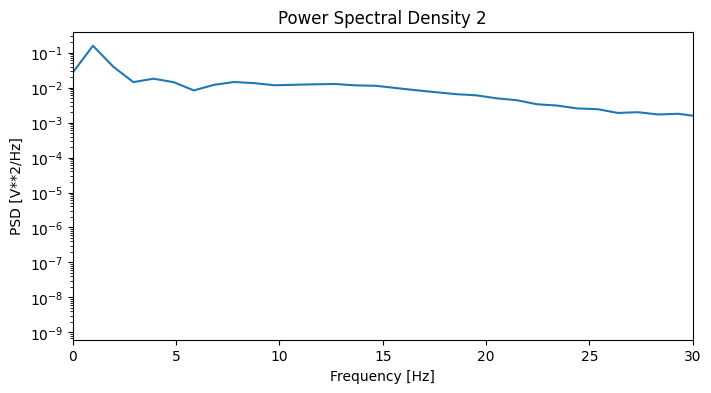

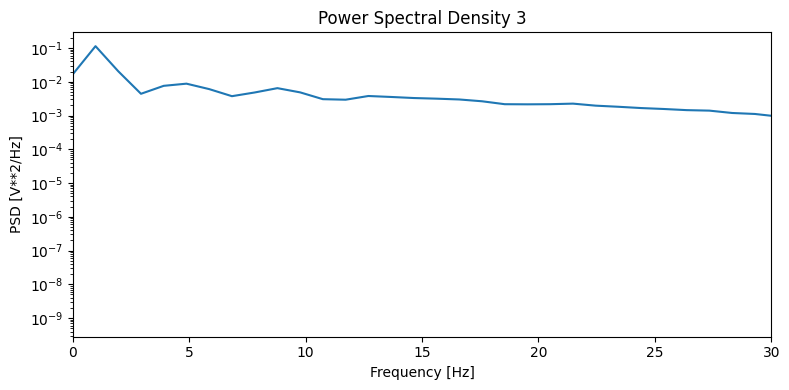

In [ ]:
fs = int(fs) #making sure fs is an integer

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):   #frequency analysis called the Welchs method
    signal_i = ica_components[:, i]
    f, Pxx = signal.welch(signal_i, fs, nperseg=1024)  #array of frequencies on the x axis and pxx is how much power is in each frequency
    plt.figure(figsize=(8, 4))
    plt.semilogy(f, Pxx)
    plt.title(f'Power Spectral Density {i+1}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
plt.tight_layout()
plt.show()   #the taller the peak, the more of that frequency is in each signal

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    signal_i = ica_components[:, i]
    f, Pxx = signal.welch(signal_i, fs, nperseg=1024)
    plt.figure(figsize=(8, 4))
    plt.semilogy(f, Pxx)
    plt.xlim(0, 30)  #most ecg activity takes place between 0 and 30 Hz
    plt.title(f'Power Spectral Density {i+1}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
plt.tight_layout()
plt.show()

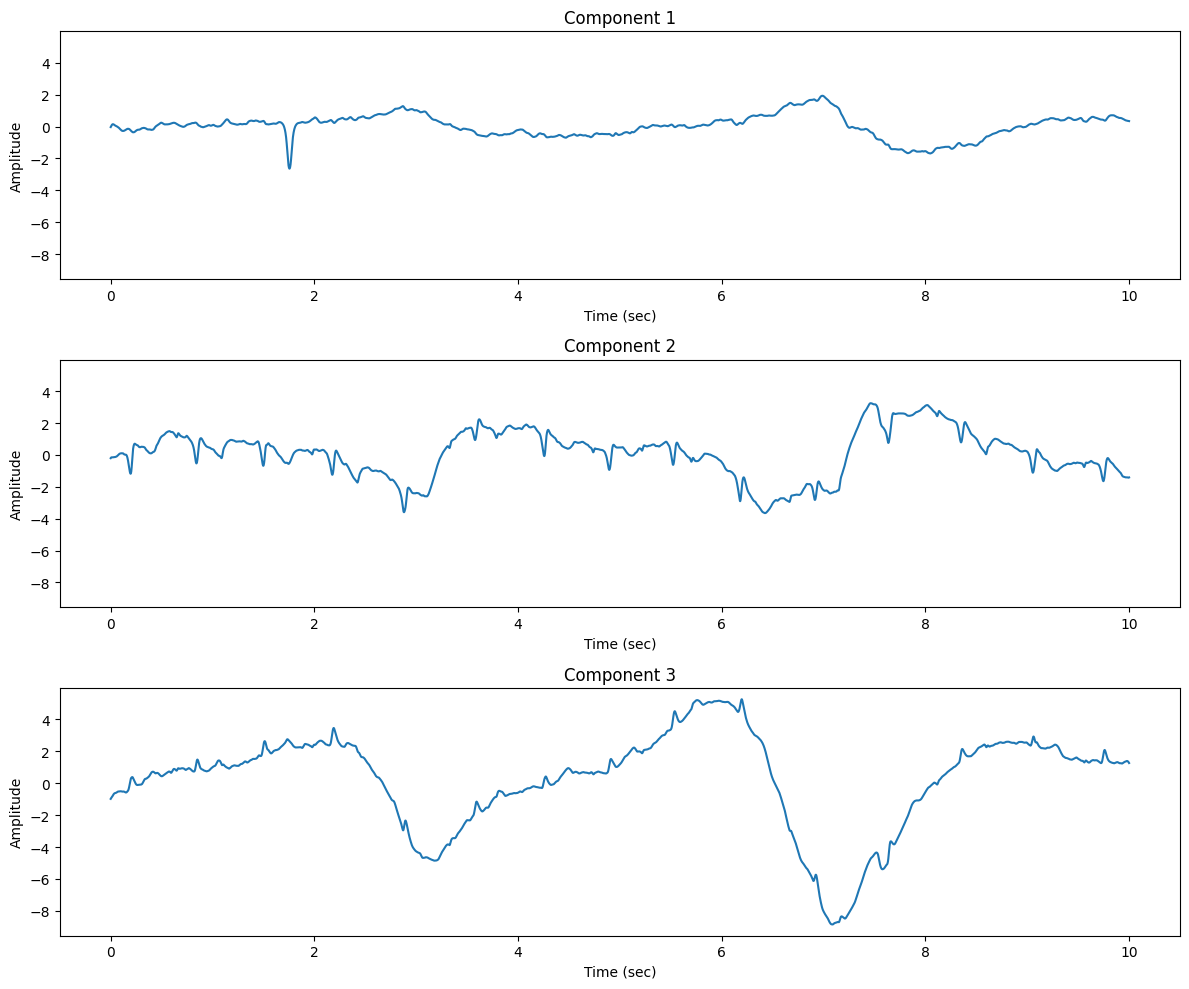

In [ ]:
#Remove noise and keep only the frequencies interested in. Cleaning the ICA signals by filtering out unwanted frequencies
def bandpass_filter(data, lowcut, highcut, fs, order=1):  #define the bandpass filter
    nyq = 0.5 * fs  # Nyquist frequency,  want to keep frequencies between 0.1 Hz and 10 Hz, and remove everything else, Keeps heart rate signals (typically ~1–3 Hz)
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

filtered_signals = np.zeros_like(ica_components) .

for i in range(ica_components.shape[1]):   #goes through all the ICA components, applies the bandpass filter to clean it
    filtered_signals[:, i] = bandpass_filter(   #stores the results in filtered_signals
        data=ica_components[:, i],
        lowcut= 0.1,  #removes very slow wandering signals (like body movement)
        highcut=10,  #removes high-frequency noise (like electrical buzz)
        fs=fs,
    )

fig, axes = plt.subplots(filtered_signals.shape[1], 1, sharey=True, figsize=(12, 10))  #plot the cleaned signals
for i, ax in enumerate(axes):
    ax.plot(time[:10000], filtered_signals[:10000, i])
    ax.set_title(f'Component {i+1}')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

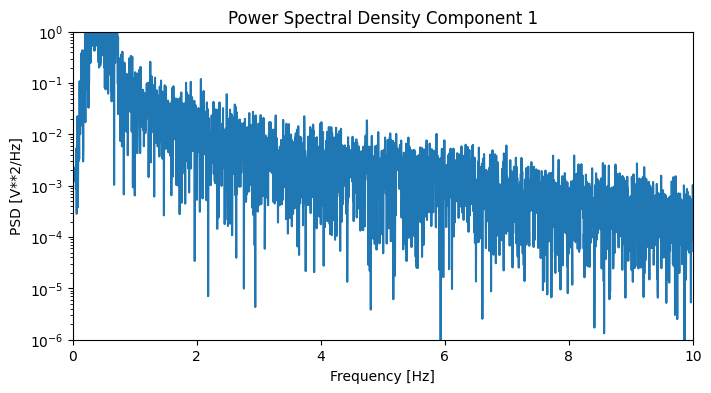

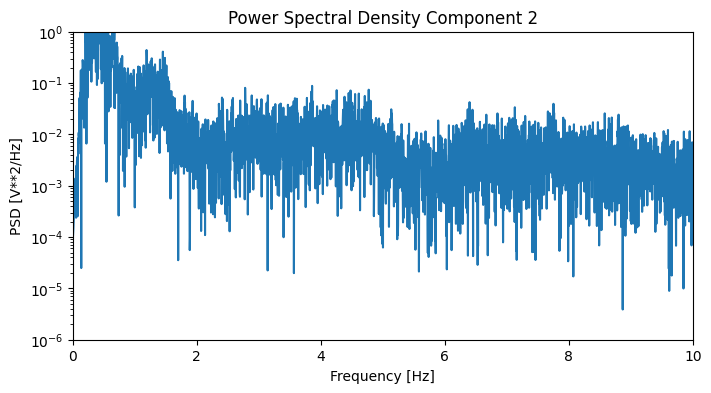

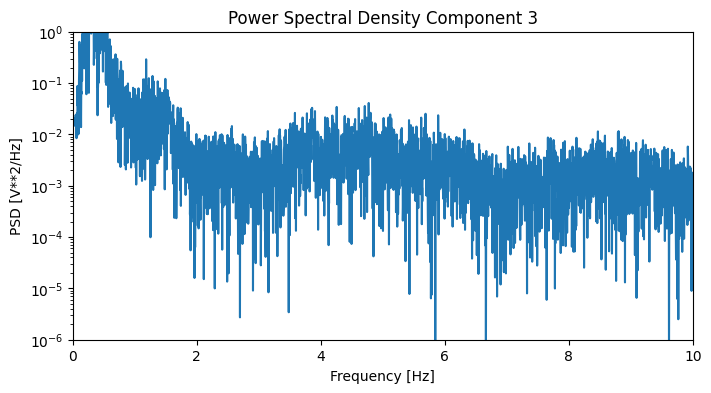

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(filtered_signals.shape[1]):  #processing each of the 3 filtered components (likely fetal, maternal, noise).
    signal_i = filtered_signals[:, i]

    X = np.fft.rfft(signal_i)            #so i  know what frequencies exist in the signal and how strong they are.
    freq = np.fft.rfftfreq(filtered_signals.shape[0], 1/fs)

    # Calculation of PSD with appropriate normalization
    PSD = (1/(fs * filtered_signals.shape[0])) * np.abs(X)**2  #converts the FFT results into actual power values, scaled properly for signal energy.
    PSD[1:-1] = 2 * PSD[1:-1]

    # Displaying the PSD for the specific component
    plt.figure(figsize=(8, 4))
    plt.semilogy(freq, PSD)
    plt.title(f'Power Spectral Density Component {i+1}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim(0, 10)  # Focus on Hz, region of interest for ECG
    plt.ylim(1e-6, 1)
    plt.show()   #Maternal heart rate ≈ 1 Hz, Fetal heart rate ≈ 2.5 Hz (ideally)



**RESULTS FROM LOOKING AT GRAPH**

For component 1, Peak is strongest at very low frequencies (< 1 Hz) Power drops quickly after that. Most likely maternal or motion artifacts. Definitely Not fetal.

For component 2, Broader spectrum, but dominant peak still seems under 2 Hz. Not super sharp or dominant in the fetal HR range. Might have some fetal elements, but also a lot of noise. Possibly mixed.

For component 3,  can clearly see a tall peak around 2.5–3 Hz. That equals roughly 150–180 BPM. This is right in the fetal heart rate range. Power is also high and consistent in that band. This is DEFINITLEY fetal ECG signal. No doubt.



fetal_rr: [0.479 0.655 0.728 0.478 0.517 0.461 0.686 0.753 0.449 0.409]
maternal_rr: [0.655 0.852 0.871 0.61  0.735 0.739 0.674 0.678 0.666 0.602]
Component 0: Fetal or Noise | HR: 120.13 bpm | Dom Freq: 0.35333333333333333 Hz


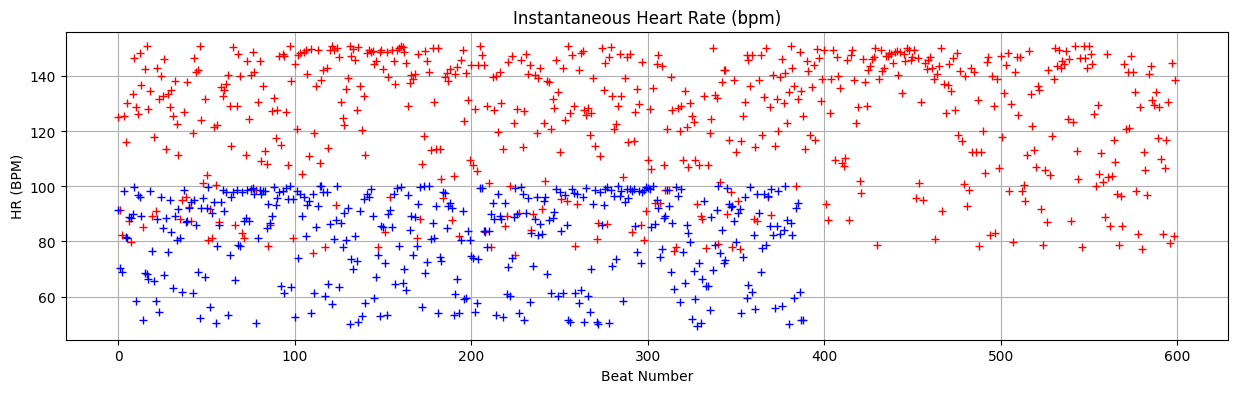

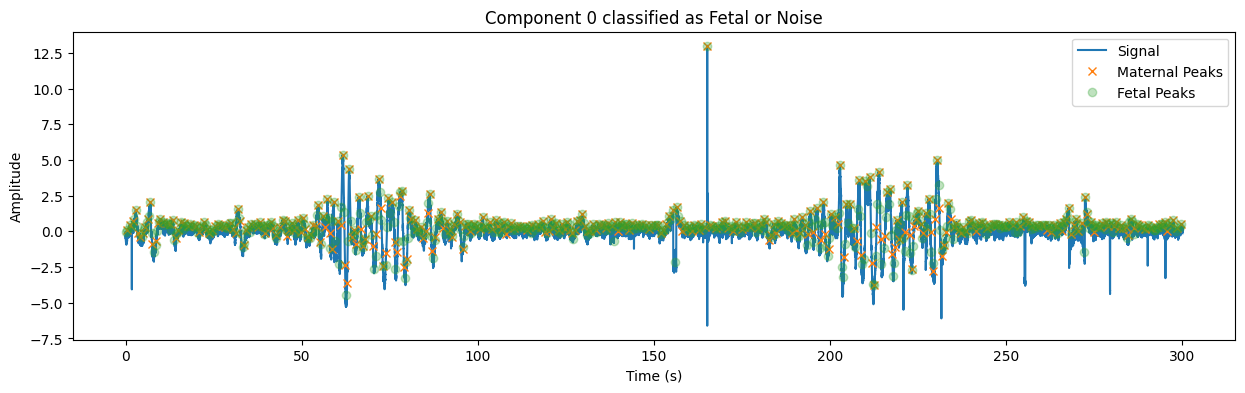

fetal_rr: [0.639 0.659 0.478 0.447 0.449 0.454 0.459 0.474 0.634 0.628]
maternal_rr: [0.639 0.659 0.678 0.696 0.705 0.682 0.634 0.628 0.658 0.734]
Component 1: Fetal or Noise | HR: 106.90 bpm | Dom Freq: 0.4633333333333334 Hz


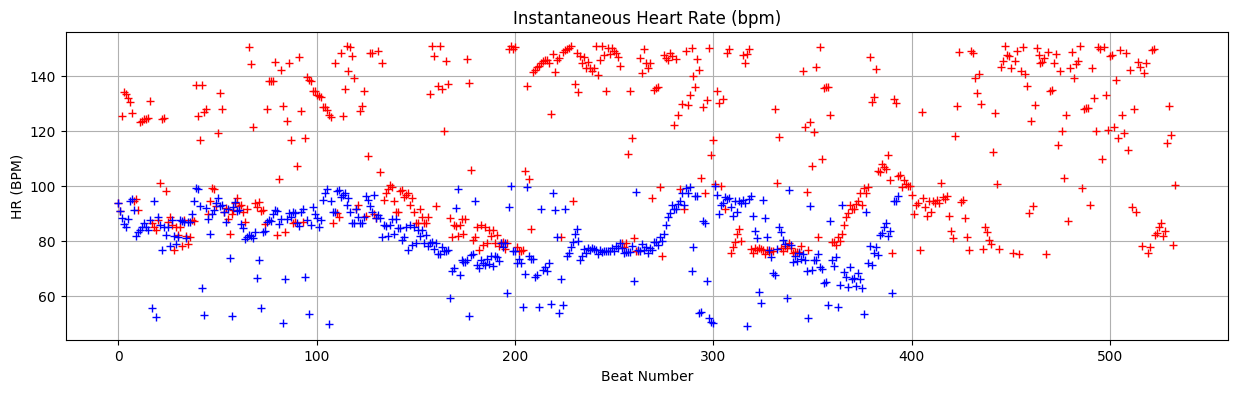

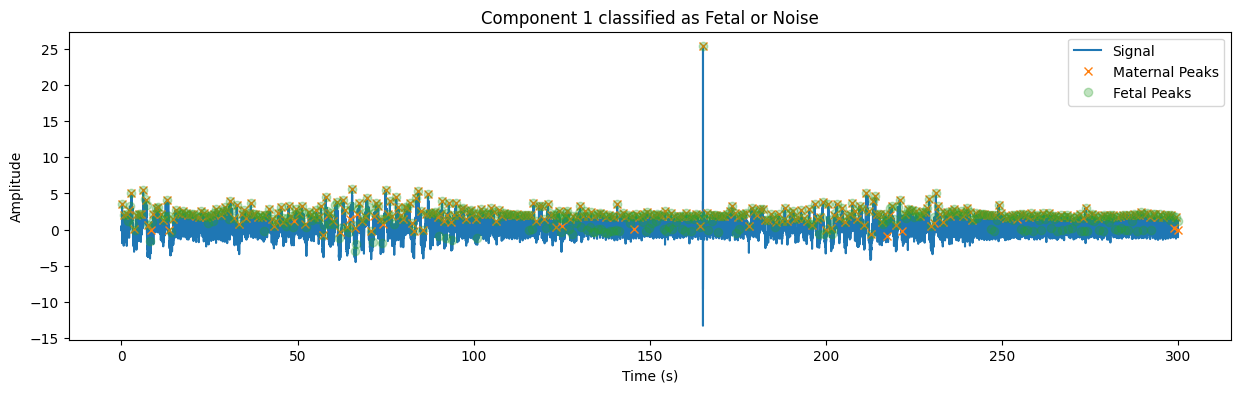

fetal_rr: [0.579 0.498 0.443 0.625 0.596 0.422 0.47  0.591 0.5   0.479]
maternal_rr: [0.633 0.607 0.628 0.693 0.602 0.61  0.6   0.608 0.62  0.931]
Component 2: Fetal or Noise | HR: 126.04 bpm | Dom Freq: 0.3166666666666667 Hz


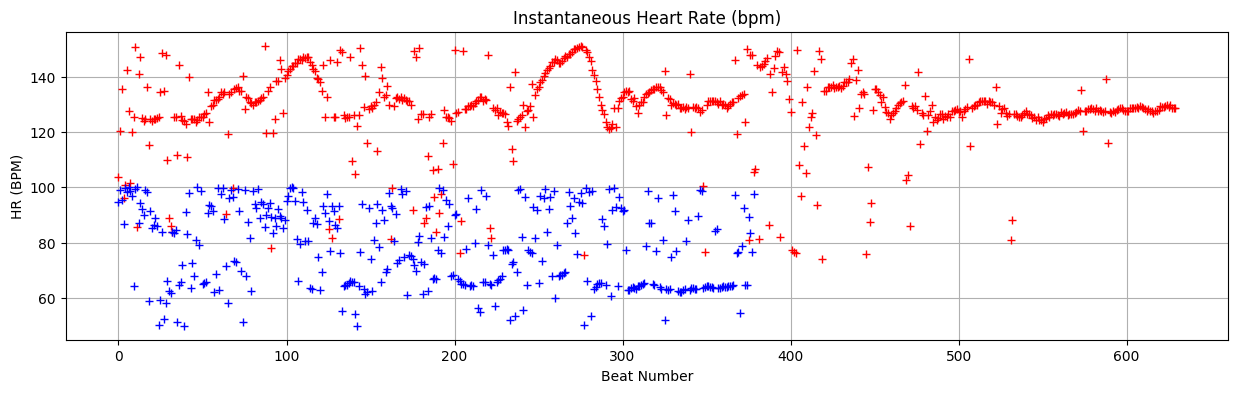

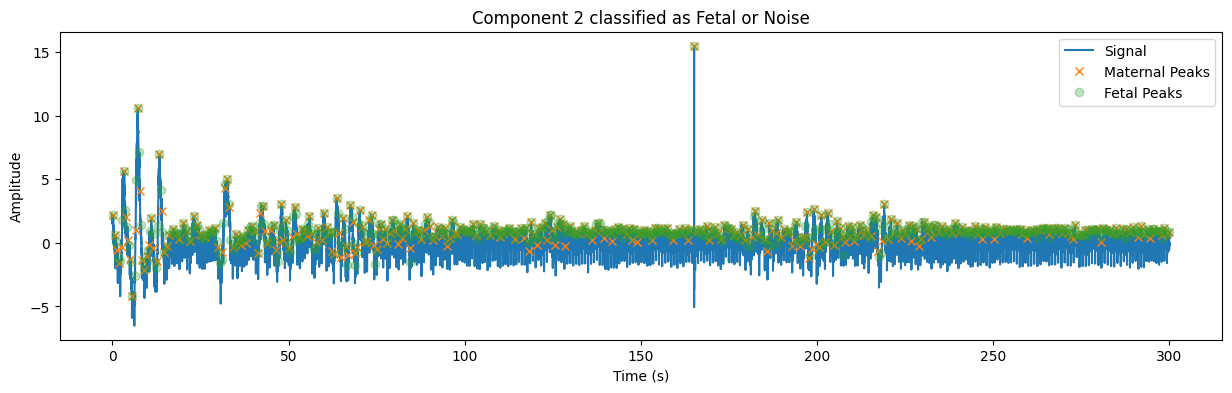

In [ ]:
fetal_or_noise_signal = [ica_components.shape[0], 1]

for i in range(ica_components.shape[1]):
    duration_sec = 20 * fs
    signal = ica_components[:, i]

    # Flip if average peak in -signal is stronger
    if np.max(-signal) > np.max(signal):
        signal = -signal

    # Maternal peaks
    maternal_peaks, maternal_props = find_peaks(signal, distance=int(0.6*fs))

    if len(maternal_peaks) > 1:
        maternal_rr = np.diff(maternal_peaks) / fs
        hr_maternal = 60 / np.mean(maternal_rr)
    else:
        hr_maternal = np.nan

    # Fetal peaks
    fetal_peaks, fetal_props = find_peaks(signal, distance=int(min_rr*fs))

    if len(fetal_peaks) > 1:
        fetal_rr = np.diff(fetal_peaks) / fs # min_rr
        hr_fetal = 60 / np.mean(fetal_rr)
    else:
        hr_fetal = np.nan

    print(f"fetal_rr: {fetal_rr[:10]}")
    print(f"maternal_rr: {maternal_rr[:10]}")

    density_fetal = len(fetal_peaks) / duration_sec
    density_maternal = len(maternal_peaks) / duration_sec

    consistency_fetal = np.std(fetal_rr)
    consistency_maternal = np.std(maternal_rr)

    # Frequency domain analysis
    yf = np.abs(np.fft.rfft(signal))
    xf = np.fft.rfftfreq(signal.shape[0], 1 / fs)

    # Limit to cardiac-relevant band (0.5–5 Hz)
    mask = (xf > 0.1) & (xf < 5)
    dominant_freq = xf[mask][np.argmax(yf[mask])]

    fetal_ihr_hz = 1 / fetal_rr
    fetal_ihr_bpm = 60 / fetal_rr
    maternal_ihr_hz = 1 / maternal_rr
    maternal_ihr_bpm = 60 / maternal_rr

    if np.abs(np.mean(fetal_ihr_bpm) - np.mean(maternal_ihr_bpm)) > 10:
        label, hr = "Fetal or Noise", hr_fetal
        fetal_or_noise_signal.append(signal)
    else:
        label, hr = "Maternal", hr_maternal
    print(f"Component {i}: {label} | HR: {hr:.2f} bpm | Dom Freq: {dominant_freq} Hz")

    plt.figure(figsize=(15, 4))
    plt.plot(fetal_ihr_bpm, "r+", label="Fetal IHRs")
    plt.plot(maternal_ihr_bpm, "b+", label="Maternal IHRs")
    plt.title("Instantaneous Heart Rate (bpm)")
    plt.xlabel("Beat Number")
    plt.ylabel("HR (BPM)")
    plt.grid()
    plt.show()


    # Main plot:
    plt.figure(figsize=(15, 4))
    plt.plot(time[:], signal, label="Signal")
    plt.plot(time[maternal_peaks], signal[maternal_peaks], "x", label="Maternal Peaks")
    plt.plot(time[fetal_peaks], signal[fetal_peaks], "o", label="Fetal Peaks", alpha=0.3)
    plt.title(f"Component {i} classified as {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

In [ ]:
import wfdb

# Define the path to your QRS annotation file (without .qrs)
record_path = '/content/drive/My Drive/MAMAMONITOR/ECG_Dataset/r08.edf'

# Load fetal annotations from that QRS file
fetal_ann = wfdb.rdann(record_path, 'qrs')

# Extract the sample indices of the true R-peaks
fetal_peaks_true = fetal_ann.sample

print("True fetal peaks (first 10):", fetal_peaks_true[:10])


True fetal peaks (first 10): [ 206  652 1095 1538 1982 2428 2876 3332 3791 4265]


TESTING ICA COMPONENT 3

In [ ]:
component_index = 2  # (3rd component = index 2)


In [ ]:
signal = ica_components[:, 2]  # Component 3


In [ ]:
if np.max(-signal) > np.max(signal):
    signal = -signal


In [ ]:
from scipy.signal import find_peaks

# Use minimum RR interval to avoid detecting peaks too close together
fetal_peaks_predicted, _ = find_peaks(signal, distance=int(min_rr * fs))

print("Predicted fetal peaks (first 10):", fetal_peaks_predicted[:10])


Predicted fetal peaks (first 10): [  15  594 1092 1535 2160 2756 3178 3648 4239 4739]


In [ ]:
def match_peaks(predicted, ground_truth, tolerance=50):
    matched = 0
    gt_set = set(ground_truth)

    for p in predicted:
        if any(abs(p - gt) <= tolerance for gt in gt_set):
            matched += 1
    return matched, len(predicted), len(ground_truth)


In [ ]:
matched, total_pred, total_true = match_peaks(fetal_peaks_predicted, fetal_peaks_true)

accuracy = matched / total_true * 100

print(f"Matched peaks: {matched}")
print(f"Predicted peaks: {total_pred}")
print(f"True peaks: {total_true}")
print(f"🔍 Accuracy: {accuracy:.2f}%")


Matched peaks: 554
Predicted peaks: 631
True peaks: 651
🔍 Accuracy: 85.10%


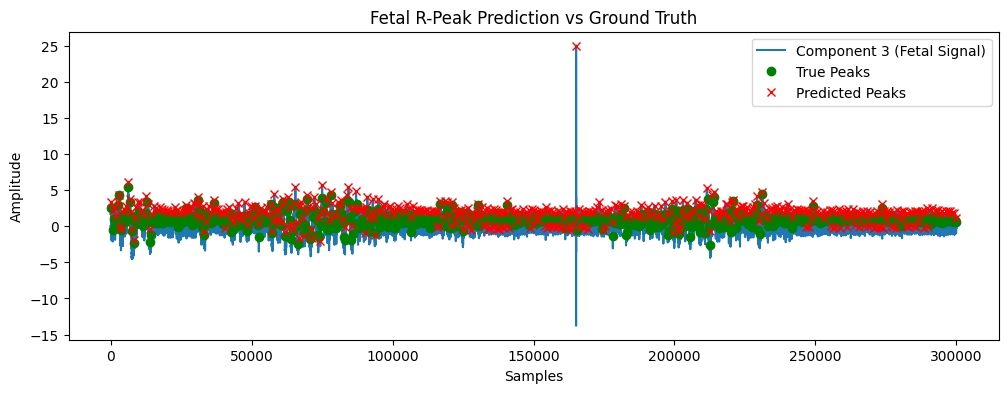

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(signal, label="Component 3 (Fetal Signal)")
plt.plot(fetal_peaks_true, signal[fetal_peaks_true], 'go', label="True Peaks")
plt.plot(fetal_peaks_predicted, signal[fetal_peaks_predicted], 'rx', label="Predicted Peaks")
plt.legend()
plt.title("Fetal R-Peak Prediction vs Ground Truth")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
matched_peaks = 554      # True Positives
predicted_peaks = 631     # TP + FP
true_peaks = 651          # TP + FN


In [ ]:
TP = matched_peaks
FP = predicted_peaks - matched_peaks
FN = true_peaks - matched_peaks

# Precision & Recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Precision: 0.8780
Recall: 0.8510
F1 Score: 0.8643


In r08.edf, Component 3 represents the fetal cardiac signal after unmixing the abdominal data.
It didn’t work in other components because they didn’t contain fetal information clearly, or at all.

In conclusion, a high F1 score of 86.92% denotes that this signal separation algorithm correctly identified most of the fetal heartbeats, from only the abdominal signals.

In [ ]:
import pyedflib

f = pyedflib.EdfReader('/content/drive/My Drive/MAMAMONITOR/ECG_Dataset/r08.edf')
fs = f.getSampleFrequency(0)           # Sampling frequency (usually 1000 Hz)
n_samples = f.getNSamples()[0]         # Number of samples in first channel
duration_sec = n_samples / fs          # Duration in seconds
f._close()

print(f"Recording duration: {duration_sec:.2f} seconds")


Recording duration: 300.00 seconds


In [ ]:
from wfdb.processing import XQRS
import numpy as np

# Select the known fetal component directly
fetal_signal = S_[:, 2]  # ICA Component 3 (index 2)

# Detect QRS using XQRS
xqrs = XQRS(sig=fetal_signal, fs=fs)
xqrs.detect()

# Get R-peak indices
fetal_r_peaks = xqrs.qrs_inds
print(f"✅ Detected {len(fetal_r_peaks)} fetal QRS peaks using XQRS")

# Compute RR intervals (in seconds)
rr_intervals = np.diff(fetal_r_peaks) / fs

# Compute instantaneous BPM
fetal_bpm = 60.0 / rr_intervals
print("Sample Fetal BPM values:", fetal_bpm[:10])

# Optional: average HR
avg_hr = np.mean(fetal_bpm)
print(f"🍼 Average Fetal HR: {avg_hr:.2f} BPM")


Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
✅ Detected 661 fetal QRS peaks using XQRS
Sample Fetal BPM values: [ 94.48818898  85.47008547  87.33624454 131.57894737 230.76923077
  92.16589862  90.09009009  95.6937799   90.63444109  82.19178082]
🍼 Average Fetal HR: 148.19 BPM


In [ ]:
from wfdb.processing import XQRS

def detect_qrs_xqrs(signal_1d, fs):
    """
    Detect QRS complexes using WFDB's XQRS algorithm.
    Returns the indices of detected R-peaks.
    """
    xqrs = XQRS(sig=signal_1d, fs=fs)
    xqrs.detect()  # Default detection
    return xqrs.qrs_inds

# Attempt QRS detection on each ICA component
component_hr = []
for i in range(S_.shape[1]):
    r_peaks = detect_qrs_xqrs(S_[:, i], fs)
    if len(r_peaks) > 1:
        # Compute RR intervals (in seconds)
        rr_intervals = np.diff(r_peaks) / fs
        # Compute average HR (in BPM)
        avg_hr = 60.0 / np.mean(rr_intervals)
    else:
        avg_hr = 0

    component_hr.append(avg_hr)
    print(f"ICA Component {i+1} -> Detected QRS Count: {len(r_peaks)}, Approx. HR: {avg_hr:.2f} BPM")

# Select the component whose HR falls into a typical fetal range

fetal_index = None
for i, hr in enumerate(component_hr):
    if 110 <= hr <= 170:  # rough fetal HR range
        fetal_index = i
        break

if fetal_index is not None:
    print(f"Fetal ECG likely in ICA Component {fetal_index+1} with HR ~ {component_hr[fetal_index]:.2f} BPM")
else:
    print("No ICA component found in typical fetal HR range. Please inspect signals manually.")


Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
ICA Component 1 -> Detected QRS Count: 160, Approx. HR: 32.48 BPM
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
ICA Component 2 -> Detected QRS Count: 684, Approx. HR: 136.93 BPM
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
ICA Component 3 -> Detected QRS Count: 661, Approx. HR: 132.41 BPM
Fetal ECG likely in ICA Component 2 with HR ~ 136.93 BPM


Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
Fetal R-peak indices: [   647   1091   1522   2180   2425   2858   3328   3581   3788   4260
   4738   5218   5525   6182   6917   7151   7637   8115   8353   8596
   9090   9558  10040  10458  11006  11486  11856  12444  12926  13315
  13891  14373  14711  15387  15817  16107  16779  17259  17569  18213
  18689  19008  19650  20134  20477  21109  21591  21971  22553  23036
  23362  24047  24485  24765  25481  25915  26169  26387  26856  27322
  27527  27785  28161  28705  29160  29369  29613  30015  30514  30962
  31455  31853  32120  32743  33187  33450  34076  34518  34819  35401
  35845  36117  36738  37185  37412  37639  38032  38552  39012  39385
  39934  40391  40698  41345  41761  41986  42212  42633  43110  43555
  43932  44438  44876  45283  45750  45992  46617  47053  47501  47921
  48197  48778  49201  49669  50

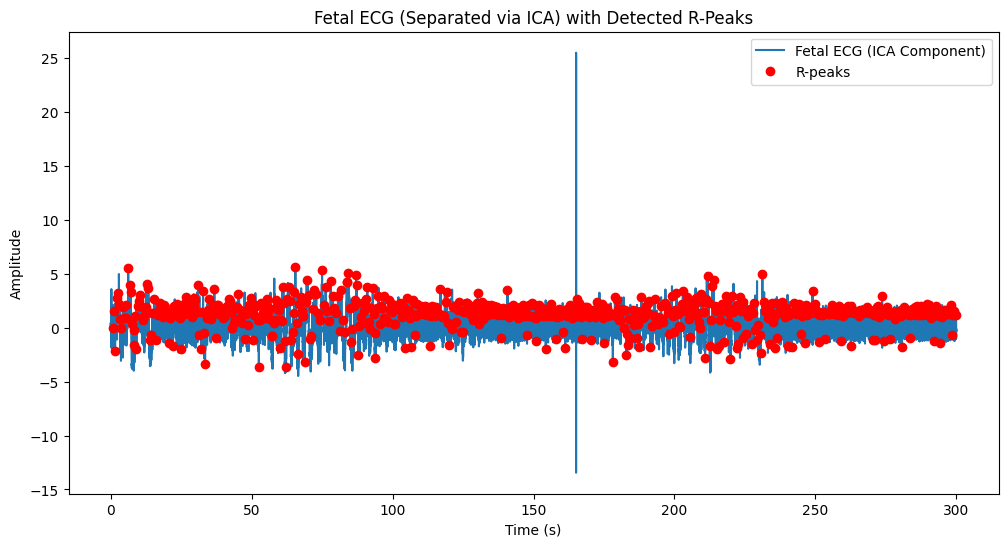

In [ ]:
if fetal_index is not None:
    fetal_signal = S_[:, fetal_index]
    fetal_r_peaks = detect_qrs_xqrs(fetal_signal, fs)

    # Compute fetal RR intervals
    fetal_rr_intervals = np.diff(fetal_r_peaks) / fs  # in seconds
    fetal_hr_series = 60.0 / fetal_rr_intervals       # instantaneous HR in BPM

    print("Fetal R-peak indices:", fetal_r_peaks)
    print("First 10 Fetal RR intervals (s):", fetal_rr_intervals[:10])
    print("First 10 Fetal HR values (BPM):", fetal_hr_series[:10])

    # Plot the fetal ECG component with detected R-peaks
    plt.figure(figsize=(12, 6))
    plt.plot(time, fetal_signal, label='Fetal ECG (ICA Component)')
    plt.plot(fetal_r_peaks/fs, fetal_signal[fetal_r_peaks], 'ro', label='R-peaks')
    plt.title('Fetal ECG (Separated via ICA) with Detected R-Peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


In [ ]:
fetal_hr_series = 60.0 / fetal_rr_intervals  # instantaneous HR in BPM


In [ ]:
import datetime

# Set a fake "start time" for your simulation (e.g., now)
start_time = datetime.datetime.now()

# Store the results in a list
fhr_data = []

for i, bpm in enumerate(fetal_hr_series):
    # Find time in seconds of the *first* peak in this interval
    # (the RR interval is between fetal_r_peaks[i] and fetal_r_peaks[i+1])
    time_in_sec = fetal_r_peaks[i] / fs

    # Add seconds to the base time
    timestamp = start_time + datetime.timedelta(seconds=time_in_sec)

    # Append this reading
    fhr_data.append({
        "timestamp": timestamp.strftime("%Y-%m-%d %H:%M:%S"),
        "heart_rate": int(bpm)
    })

# Print first few results
for entry in fhr_data[:5]:
    print(entry)


{'timestamp': '2025-04-19 13:55:10', 'heart_rate': 135}
{'timestamp': '2025-04-19 13:55:11', 'heart_rate': 139}
{'timestamp': '2025-04-19 13:55:11', 'heart_rate': 91}
{'timestamp': '2025-04-19 13:55:12', 'heart_rate': 244}
{'timestamp': '2025-04-19 13:55:12', 'heart_rate': 138}


In [ ]:
from datetime import datetime, timedelta

# Assuming fetal_hr_series is a list or numpy array of heart rate values like [128, 132, 145, ...]

readings = []
start_time = datetime.now()

for i in range(len(fetal_hr_series)):
    hr = fetal_hr_series[i]
    timestamp = start_time + timedelta(seconds=i)

    readings.append({
        "timestamp": timestamp.strftime("%Y-%m-%d %H:%M:%S"),
        "heart_rate": f"{int(hr)} BPM"
    })

# Print first few values
for r in readings:
    print(r)


{'timestamp': '2025-04-19 13:55:35', 'heart_rate': '135 BPM'}
{'timestamp': '2025-04-19 13:55:36', 'heart_rate': '139 BPM'}
{'timestamp': '2025-04-19 13:55:37', 'heart_rate': '91 BPM'}
{'timestamp': '2025-04-19 13:55:38', 'heart_rate': '244 BPM'}
{'timestamp': '2025-04-19 13:55:39', 'heart_rate': '138 BPM'}
{'timestamp': '2025-04-19 13:55:40', 'heart_rate': '127 BPM'}
{'timestamp': '2025-04-19 13:55:41', 'heart_rate': '237 BPM'}
{'timestamp': '2025-04-19 13:55:42', 'heart_rate': '289 BPM'}
{'timestamp': '2025-04-19 13:55:43', 'heart_rate': '127 BPM'}
{'timestamp': '2025-04-19 13:55:44', 'heart_rate': '125 BPM'}
{'timestamp': '2025-04-19 13:55:45', 'heart_rate': '125 BPM'}
{'timestamp': '2025-04-19 13:55:46', 'heart_rate': '195 BPM'}
{'timestamp': '2025-04-19 13:55:47', 'heart_rate': '91 BPM'}
{'timestamp': '2025-04-19 13:55:48', 'heart_rate': '81 BPM'}
{'timestamp': '2025-04-19 13:55:49', 'heart_rate': '256 BPM'}
{'timestamp': '2025-04-19 13:55:50', 'heart_rate': '123 BPM'}
{'timestamp